<a href="https://colab.research.google.com/github/abhigyanpal1/trader-sentiment-hyperliquid/blob/main/DS_Task_PrimeTrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1) Setup & installs**

In [1]:
# Install deps
!pip -q install pandas numpy matplotlib scikit-learn lightgbm pyarrow

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

# Output folders
for d in ["outputs", "outputs/figures", "outputs/tables"]:
    os.makedirs(d, exist_ok=True)

pd.set_option("display.max_columns", 200)


# **2) CONFIG — edit here if needed**

In [2]:
CONFIG = {
    # File paths (already uploaded in Colab)
    "fear_greed_path": "/content/fear_greed_index.csv",
    "trades_path": "/content/historical_data.csv",

    # Fear/Greed Index (FGI) columns
    "fgi_date_col": "Date",
    "fgi_class_col": "Classification",  # values like "Fear"/"Greed"

    # Hyperliquid trade logs columns (adjust if names differ)
    "account_col": "account",
    "symbol_col": "symbol",
    "price_col": "execution price",     # sometimes "execution_price" or "price"
    "size_col": "size",
    "side_col": "side",                 # "buy"/"sell" or "long"/"short"
    "time_col": "time",                 # epoch ms or ISO string
    "event_col": "event",               # optional
    "pnl_col": "closedPnL",             # realized pnl per trade/close (optional)
    "lev_col": "leverage",              # optional

    # If trade 'time' is epoch *milliseconds* set True; set False for seconds/ISO
    "trade_time_ms": True,
}
CONFIG


{'fear_greed_path': '/content/fear_greed_index.csv',
 'trades_path': '/content/historical_data.csv',
 'fgi_date_col': 'Date',
 'fgi_class_col': 'Classification',
 'account_col': 'account',
 'symbol_col': 'symbol',
 'price_col': 'execution price',
 'size_col': 'size',
 'side_col': 'side',
 'time_col': 'time',
 'event_col': 'event',
 'pnl_col': 'closedPnL',
 'lev_col': 'leverage',
 'trade_time_ms': True}

# **3) Loaders**

In [4]:
import pandas as pd
pd.read_csv("/content/fear_greed_index.csv").head()
pd.read_csv("/content/fear_greed_index.csv").columns


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

In [11]:
# --- STEP 3 (corrected for your trades CSV headers) ---

# Update CONFIG to match your CSV column names
CONFIG["fgi_date_col"] = "date"
CONFIG["fgi_class_col"] = "classification"

CONFIG["account_col"] = "Account"
CONFIG["symbol_col"]  = "Coin"
CONFIG["price_col"]   = "Execution Price"
CONFIG["size_col"]    = "Size Tokens"       # or "Size USD" if you prefer
CONFIG["side_col"]    = "Side"
CONFIG["time_col"]    = "Timestamp"         # can switch to "Timestamp IST" if needed
CONFIG["pnl_col"]     = "Closed PnL"
CONFIG["event_col"]   = None                 # not present
CONFIG["lev_col"]     = None                 # not present
CONFIG["trade_time_ms"] = False              # looks like it's in seconds or ISO

def load_fgi(path, date_col, class_col):
    fgi = pd.read_csv(path)
    fgi = fgi.rename(columns={date_col: "date", class_col: "classification"})
    fgi["date"] = pd.to_datetime(fgi["date"], utc=True, errors="coerce").dt.date
    fgi["sentiment_raw"] = fgi["classification"].astype(str).str.strip().str.lower()
    fgi["sentiment_bin"] = fgi["sentiment_raw"].map({"greed": 1, "fear": 0}).fillna(-1)
    fgi = fgi.sort_values("date").drop_duplicates("date", keep="last")
    return fgi

def load_trades(path, cfg):
    df = pd.read_csv(path)
    rename = {
        cfg["account_col"]: "account",
        cfg["symbol_col"]:  "symbol",
        cfg["price_col"]:   "price",
        cfg["size_col"]:    "size",
        cfg["side_col"]:    "side",
        cfg["time_col"]:    "time",
        cfg["pnl_col"]:     "closedPnL"
    }
    df = df.rename(columns=rename)

    if cfg["trade_time_ms"]:
        df["timestamp"] = pd.to_datetime(df["time"], unit="ms", utc=True, errors="coerce")
    else:
        df["timestamp"] = pd.to_datetime(df["time"], utc=True, errors="coerce")

    df["date"] = df["timestamp"].dt.date
    df["side"] = df["side"].astype(str).str.lower().replace({"buy":"long","sell":"short"})

    for col in ["price","size","closedPnL"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

# Load datasets
fgi = load_fgi(CONFIG["fear_greed_path"], CONFIG["fgi_date_col"], CONFIG["fgi_class_col"])
trades = load_trades(CONFIG["trades_path"], CONFIG)

print(f"FGI: {fgi.shape} rows | cols: {list(fgi.columns)}")
print(f"Trades: {trades.shape} rows | cols: {list(trades.columns)}")
display(fgi.head(3))
display(trades.head(3))


FGI: (2644, 6) rows | cols: ['timestamp', 'value', 'classification', 'date', 'sentiment_raw', 'sentiment_bin']
Trades: (211224, 18) rows | cols: ['account', 'symbol', 'price', 'size', 'Size USD', 'side', 'Timestamp IST', 'Start Position', 'Direction', 'closedPnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'time', 'timestamp', 'date']


,timestamp,value,classification,date,sentiment_raw,sentiment_bin
0,1517463000,30,Fear,2018-02-01,fear,0.0
1,1517549400,15,Extreme Fear,2018-02-02,extreme fear,-1.0
2,1517635800,40,Fear,2018-02-03,fear,0.0


,account,symbol,price,size,Size USD,side,Timestamp IST,Start Position,Direction,closedPnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,time,timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,long,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,1970-01-01 00:28:50+00:00,1970-01-01
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,long,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,1970-01-01 00:28:50+00:00,1970-01-01
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,long,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,1970-01-01 00:28:50+00:00,1970-01-01


# **4) Data Cleaning, Daily Aggregation, and Exploratory Analysis**

Rows after join: 1102
Rows with sentiment: 653
Avg Daily PnL by Sentiment:
 sentiment_bin
Fear     8381.818796
Greed    2943.370427
Name: pnl_sum, dtype: float64


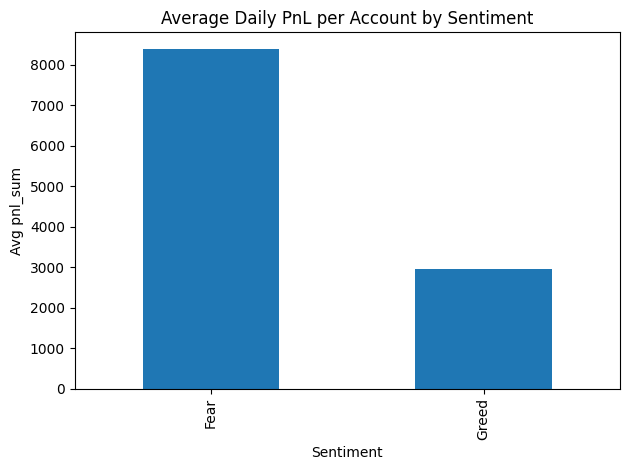

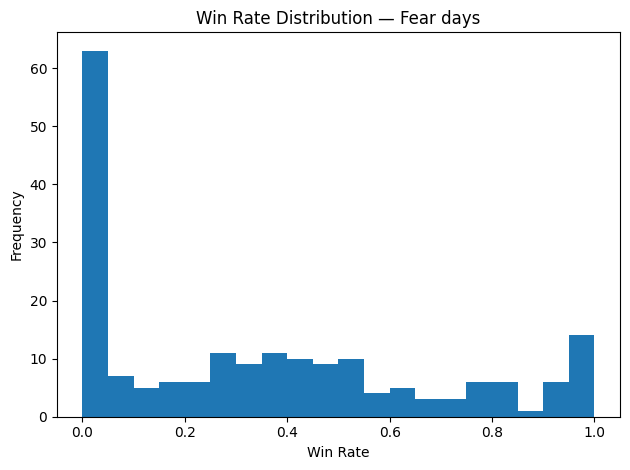

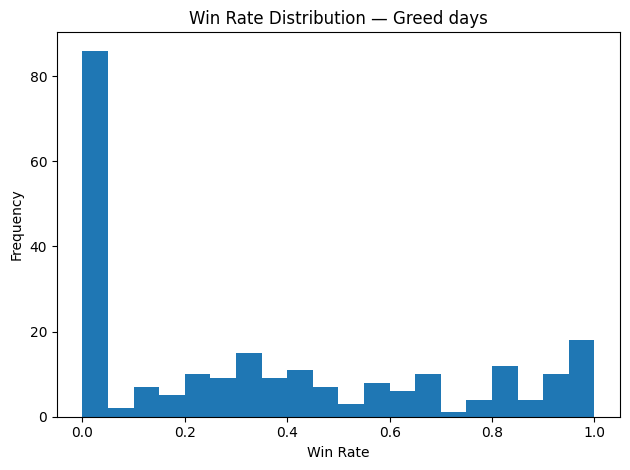

<Figure size 640x480 with 0 Axes>

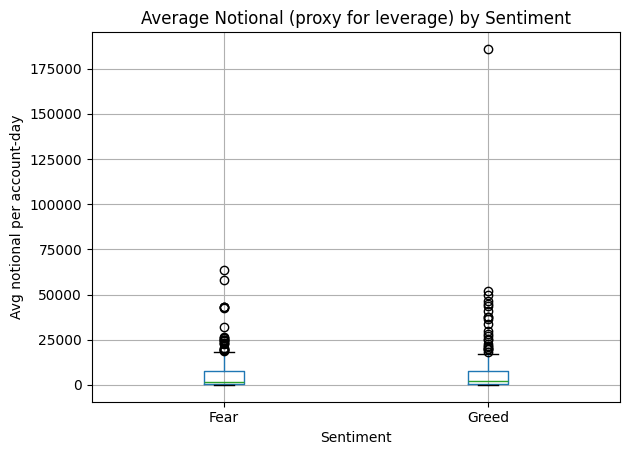

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------- 4) CLEAN & PREPARE --------

# 1) Timestamp/date cleaning for trades
if "Timestamp IST" in trades.columns:
    ts_ist = pd.to_datetime(trades["Timestamp IST"], errors="coerce")
    ts_ist = ts_ist.dt.tz_localize("Asia/Kolkata", nonexistent="NaT", ambiguous="NaT")
    trades["timestamp"] = ts_ist.dt.tz_convert("UTC")
elif "timestamp" in trades.columns and pd.api.types.is_datetime64_any_dtype(trades["timestamp"]):
    if trades["timestamp"].dt.tz is None:
        trades["timestamp"] = trades["timestamp"].dt.tz_localize("UTC")
    else:
        trades["timestamp"] = trades["timestamp"].dt.tz_convert("UTC")
else:
    trades["timestamp"] = pd.to_datetime(trades["time"], utc=True, errors="coerce")

# Clean 'date' (UTC calendar date)
trades["date"] = trades["timestamp"].dt.date
trades = trades[trades["timestamp"].notna()].copy()

# 2) Clean FGI dates
fgi["date"] = pd.to_datetime(fgi["date"], errors="coerce").dt.date
fgi = fgi[fgi["date"].notna()].copy()

# 3) Clean Closed PnL → numeric
if "closedPnL" in trades.columns:
    raw = trades["closedPnL"].astype(str)
    neg = raw.str.match(r"^\(.*\)$")
    cleaned = (raw
               .str.replace(r"[,\s₹$]", "", regex=True)
               .str.replace(r"[\(\)]", "", regex=True))
    trades["closedPnL"] = pd.to_numeric(cleaned, errors="coerce")
    trades.loc[neg, "closedPnL"] = -trades.loc[neg, "closedPnL"].abs()

# 4) Compute notional (tokens * price)
trades["notional"] = pd.to_numeric(trades["size"], errors="coerce").abs() * pd.to_numeric(trades["price"], errors="coerce")

# -------- 5) DAILY METRICS --------

def daily_metrics(tr):
    g = tr.groupby(["date","account"], dropna=False)
    out = g.agg(
        trades_count=("symbol","count"),
        symbols_nunique=("symbol","nunique"),
        side_long_share=("side", lambda s: (s=="long").mean() if len(s) else np.nan),
        notional_sum=("notional","sum"),
        leverage_avg=("notional","mean"),  # proxy for leverage
    ).reset_index()

    if "closedPnL" in tr.columns:
        gg = tr.groupby(["date","account"])
        out = out.merge(gg["closedPnL"].sum().rename("pnl_sum").reset_index(), on=["date","account"])
        out = out.merge(gg["closedPnL"].mean().rename("pnl_mean").reset_index(), on=["date","account"])
        out = out.merge(gg["closedPnL"].apply(lambda x: (x>0).mean()).rename("win_rate").reset_index(),
                        on=["date","account"])
    else:
        out["pnl_sum"] = np.nan
        out["pnl_mean"] = np.nan
        out["win_rate"] = np.nan
    return out

daily = daily_metrics(trades)

# -------- 6) SENTIMENT FEATURES --------

fg = fgi.sort_values("date").copy()
for w in [3,7,14]:
    fg[f"sentiment_bin_ma{w}"] = fg["sentiment_bin"].replace(-1, np.nan).rolling(w, min_periods=1).mean()

def streak(vals, pos=1):
    run=0; out=[]
    for v in vals:
        run = run+1 if v==pos else 0
        out.append(run)
    return out

fg["greed_streak"] = streak(fg["sentiment_bin"].tolist(), pos=1)
fg["fear_streak"]  = streak((1 - fg["sentiment_bin"]).tolist(), pos=1)

# -------- 7) JOIN --------

df = daily.merge(fg.drop(columns=["sentiment_raw"]), on="date", how="left")
print("Rows after join:", df.shape[0])
print("Rows with sentiment:", df["sentiment_bin"].notna().sum())

# -------- 8) SAFE EDA --------

eda = df[df["sentiment_bin"].isin([0,1])].copy()

if eda.empty or eda["pnl_sum"].dropna().empty:
    print("No overlapping dates or pnl_sum empty after join.")
else:
    # Avg PnL
    agg = eda.groupby("sentiment_bin")["pnl_sum"].mean().rename({0:"Fear",1:"Greed"})
    print("Avg Daily PnL by Sentiment:\n", agg)

    plt.figure()
    agg.plot(kind="bar")
    plt.title("Average Daily PnL per Account by Sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel("Avg pnl_sum")
    plt.tight_layout()
    plt.show()

    # Win-rate distributions
    for label, grp in eda.groupby("sentiment_bin"):
        wr = grp["win_rate"].dropna()
        if len(wr) == 0:
            continue
        plt.figure()
        plt.hist(wr, bins=20)
        plt.title(f"Win Rate Distribution — {'Greed' if label==1 else 'Fear'} days")
        plt.xlabel("Win Rate")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # Notional proxy for leverage
    box_df = eda.copy()
    box_df["sentiment"] = np.where(box_df["sentiment_bin"]==1, "Greed","Fear")
    plt.figure()
    box_df.boxplot(column="leverage_avg", by="sentiment")
    plt.suptitle("")
    plt.title("Average Notional (proxy for leverage) by Sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel("Avg notional per account-day")
    plt.tight_layout()
    plt.show()


# **5) Sentiment Transition → Next-Day PnL**

Mean Next-Day PnL by Transition (0=Fear,1=Greed):
 transition
1.0->nan      16429.251472
0.0->0.0      10687.447093
-1.0->0.0      9803.671701
1.0->0.0       9316.406978
1.0->-1.0      5459.069038
-1.0->-1.0     5283.220742
1.0->1.0       4407.219435
-1.0->1.0      4258.528934
0.0->-1.0      1773.503696
0.0->1.0       1364.154396
Name: next_pnl_sum, dtype: float64


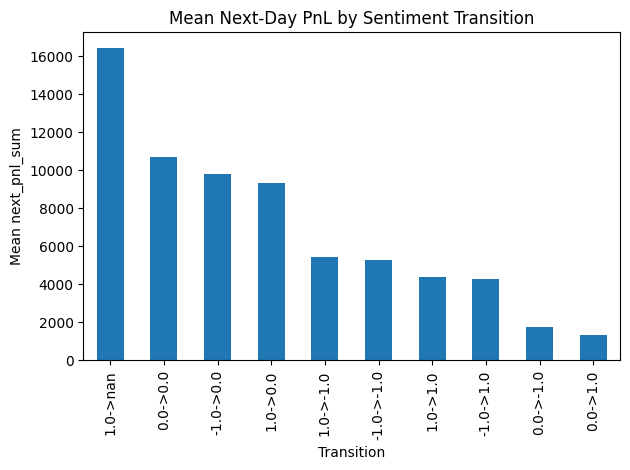

In [20]:
# Build next-day pnl per account
df = df.sort_values(["account","date"]).copy()
df["next_pnl_sum"] = df.groupby("account")["pnl_sum"].shift(-1)

# Day-level transition (0=fear, 1=greed)
fg2 = fg.sort_values("date").copy()
fg2["sentiment_next"] = fg2["sentiment_bin"].shift(-1)
fg2["transition"] = fg2["sentiment_bin"].astype(str) + "->" + fg2["sentiment_next"].astype(str)

df = df.merge(fg2[["date","transition"]], on="date", how="left")

# Aggregate effect on next-day pnl
tran = df.dropna(subset=["transition","next_pnl_sum"])
tran_agg = tran.groupby("transition")["next_pnl_sum"].mean().sort_values(ascending=False)
print("Mean Next-Day PnL by Transition (0=Fear,1=Greed):\n", tran_agg)

# Plot (safe)
if not tran_agg.empty:
    import matplotlib.pyplot as plt
    plt.figure()
    tran_agg.plot(kind="bar")
    plt.title("Mean Next-Day PnL by Sentiment Transition")
    plt.xlabel("Transition")
    plt.ylabel("Mean next_pnl_sum")
    plt.tight_layout()
    plt.savefig("outputs/figures/nextday_pnl_by_transition.png", dpi=150)
    plt.show()


# **6) Per-Trade Slices (Side × Sentiment, Symbol × Sentiment)**

In [21]:
# Attach sentiment to each trade
trade_sent = trades.merge(fg[["date","sentiment_bin"]], on="date", how="left")

# Long/short effectiveness
if "closedPnL" in trade_sent.columns:
    ls = (trade_sent[trade_sent["sentiment_bin"].isin([0,1])]
          .groupby(["sentiment_bin","side"])["closedPnL"].mean()
          .unstack())
    print("Mean closedPnL by Sentiment (rows) and Side (cols):\n", ls)

    # Symbol breakdown (top 10 by Greed)
    sym = (trade_sent[trade_sent["sentiment_bin"].isin([0,1])]
           .groupby(["symbol","sentiment_bin"])["closedPnL"].mean()
           .unstack().rename(columns={0:"Fear",1:"Greed"}))
    sym = sym.sort_values("Greed", ascending=False)
    display(sym.head(10))

    # Save tables
    (ls if ls is not None else pd.DataFrame()).to_csv("outputs/tables/side_vs_sentiment_closedpnl.csv")
    sym.to_csv("outputs/tables/symbol_vs_sentiment_closedpnl.csv")


Mean closedPnL by Sentiment (rows) and Side (cols):
 side                 long       short
sentiment_bin                        
0.0            192.527331   28.892717
1.0              4.480305  107.446020


sentiment_bin,Fear,Greed
symbol,,
USUAL,13.125868,759.791153
@85,0.000000,678.668791
MOODENG,NaN,531.655030
PEOPLE,NaN,360.646005
SOL,731.921050,330.311520
TRX,NaN,229.845254
ETHFI,39.173753,202.022961
CYBER,NaN,191.529600
HYPE,56.104967,161.581111


# **7) Save Clean Panel for Reporting**

In [22]:
keep = [
    "date","account","trades_count","symbols_nunique","side_long_share","notional_sum",
    "leverage_avg","pnl_sum","pnl_mean","win_rate",
    "sentiment_bin","sentiment_bin_ma3","sentiment_bin_ma7","sentiment_bin_ma14",
    "greed_streak","fear_streak","next_pnl_sum","transition"
]
(df[keep].copy()).to_csv("outputs/tables/account_day_panel.csv", index=False)
print("Saved -> outputs/tables/account_day_panel.csv")


Saved -> outputs/tables/account_day_panel.csv


# **8) Simple ML: Predict Profitable Day**

[LightGBM] [Info] Number of positive: 316, number of negative: 206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 522, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.605364 -> initscore=0.427866
[LightGBM] [Info] Start training from score 0.427866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

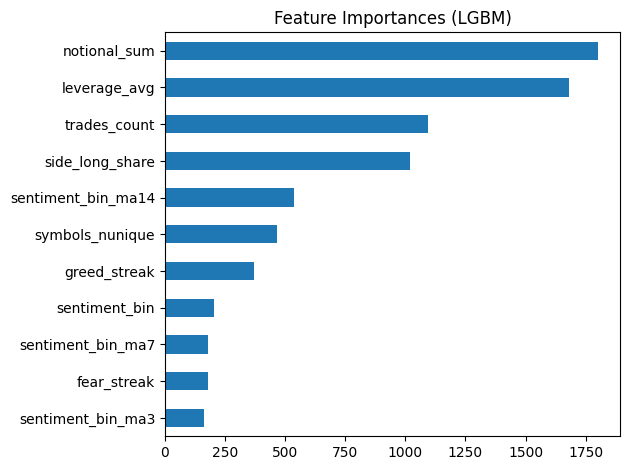

Saved -> outputs/tables/feature_importances.csv


In [23]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ml = df.copy()
ml = ml.dropna(subset=["pnl_sum","trades_count","sentiment_bin"])
ml["target_profitable"] = (ml["pnl_sum"] > 0).astype(int)

numeric_feats = [
    "trades_count","symbols_nunique","side_long_share","notional_sum",
    "leverage_avg","sentiment_bin","sentiment_bin_ma3","sentiment_bin_ma7",
    "sentiment_bin_ma14","greed_streak","fear_streak"
]
X = ml[numeric_feats].fillna(0)
y = ml["target_profitable"]

pre = ColumnTransformer([("num", StandardScaler(with_mean=False), numeric_feats)], remainder="drop")
clf = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
pipe = Pipeline([("prep", pre), ("clf", clf)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=skf, scoring="roc_auc")
print("CV AUC per fold:", np.round(scores, 4))
print("Mean CV AUC:", np.round(scores.mean(), 4))

pipe.fit(X, y)
imps = pd.Series(pipe.named_steps["clf"].feature_importances_, index=numeric_feats).sort_values()
imps.to_frame("importance").to_csv("outputs/tables/feature_importances.csv")

plt.figure()
imps.plot(kind="barh")
plt.title("Feature Importances (LGBM)")
plt.tight_layout()
plt.savefig("outputs/figures/feature_importances.png", dpi=150)
plt.show()

print("Saved -> outputs/tables/feature_importances.csv")


# **9) Quick Summary JSON (for README/report)**

In [24]:
summary = {}

# Avg pnl by sentiment (if computed earlier)
try:
    summary["avg_pnl_by_sentiment"] = {("Greed" if k==1 else "Fear"): float(v) for k,v in agg.items()}
except Exception:
    # compute on the fly if missing
    _eda = df[df["sentiment_bin"].isin([0,1])].copy()
    if not _eda.empty and _eda["pnl_sum"].notna().any():
        _agg = _eda.groupby("sentiment_bin")["pnl_sum"].mean().rename({0:"Fear",1:"Greed"})
        summary["avg_pnl_by_sentiment"] = {("Greed" if k==1 else "Fear"): float(v) for k,v in _agg.items()}
    else:
        summary["avg_pnl_by_sentiment"] = {}

# Win-rate delta
wr_fear = df.loc[df["sentiment_bin"]==0, "win_rate"].mean()
wr_greed = df.loc[df["sentiment_bin"]==1, "win_rate"].mean()
summary["winrate_fear"] = float(wr_fear) if pd.notnull(wr_fear) else None
summary["winrate_greed"] = float(wr_greed) if pd.notnull(wr_greed) else None
summary["winrate_delta_pp"] = (summary["winrate_greed"] - summary["winrate_fear"]) * 100 if None not in (summary["winrate_fear"], summary["winrate_greed"]) else None

# Best transition
try:
    best_tr = tran_agg.idxmax()
    best_val = float(tran_agg.max())
    summary["best_transition"] = {"transition": best_tr, "mean_nextday_pnl": best_val}
except Exception:
    summary["best_transition"] = None

# Model AUC
try:
    summary["cv_auc_mean"] = float(scores.mean())
except Exception:
    summary["cv_auc_mean"] = None

pd.Series(summary).to_json("outputs/tables/quick_summary.json")
print("Saved -> outputs/tables/quick_summary.json")
summary


Saved -> outputs/tables/quick_summary.json


{'avg_pnl_by_sentiment': {'Fear': 2943.370426599156},
 'winrate_fear': 0.3423336469537248,
 'winrate_greed': 0.35253911217196304,
 'winrate_delta_pp': 1.020546521823823,
 'best_transition': {'transition': '1.0->nan',
  'mean_nextday_pnl': 16429.251472076925},
 'cv_auc_mean': 0.8158981995914235}